# Concise Implementation of Linear Regression
:label:`sec_linear_concise`

Deep learning has witnessed a sort of Cambrian explosion
over the past decade.
The sheer number of techniques, applications and algorithms by far surpasses the
progress of previous decades. 
This is due to a fortuitous combination of multiple factors,
one of which is the powerful free tools
offered by a number of open-source deep learning frameworks.
Theano :cite:`Bergstra.Breuleux.Bastien.ea.2010`,
DistBelief :cite:`Dean.Corrado.Monga.ea.2012`,
and Caffe :cite:`Jia.Shelhamer.Donahue.ea.2014`
arguably represent the
first generation of such models 
that found widespread adoption.
In contrast to earlier (seminal) works like
SN2 (Simulateur Neuristique) :cite:`Bottou.Le-Cun.1988`,
which provided a Lisp-like programming experience,
modern frameworks offer automatic differentiation
and the convenience of Python.
These frameworks allow us to automate and modularize
the repetitive work of implementing gradient-based learning algorithms.

In :numref:`sec_linear_scratch`, we relied only on
(i) tensors for data storage and linear algebra;
and (ii) automatic differentiation for calculating gradients.
In practice, because data iterators, loss functions, optimizers,
and neural network layers
are so common, modern libraries implement these components for us as well.
In this section, (**we will show you how to implement
the linear regression model**) from :numref:`sec_linear_scratch`
(**concisely by using high-level APIs**) of deep learning frameworks.


In [2]:
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow_probability.substrates import jax as tfp
import jax
import jax.numpy as jnp
import optax
from flax import nnx

tfd = tfp.distributions
key = tfp.util.SeedStream(1252, salt="regression-concise")

In [4]:
# generate synthetic regression data
def gen_reg_data(w, b, seed, noise=0.01, n=500):
	key = tfp.util.SeedStream(seed, salt="gen_reg_data")
	normal = tfd.Normal(loc=0.0, scale=1.0)
	X = normal.sample((n, w.shape[0]), seed=key())
	noise = normal.sample((n, 1), seed=key()) * noise
	return X, jnp.matmul(X, jnp.reshape(w, (-1, 1))) + b + noise

In [5]:
eval_every = 100
batch_size = 250

In [17]:
train_data = gen_reg_data(w=jnp.array([2, -3.4]), b=4.2, n=500, seed=714)
train_data = tf.data.Dataset.from_tensor_slices(train_data).repeat(1000).shuffle(200)
train_data = train_data.batch(batch_size=batch_size, drop_remainder=True).prefetch(1)

In [18]:
tf.data.experimental.cardinality(train_data)

<tf.Tensor: shape=(), dtype=int64, numpy=2000>

In [19]:
test_data = gen_reg_data(w=jnp.array([2, -3.4]), b=4.2, n=250, seed=714)
test_data = tf.data.Dataset.from_tensor_slices(test_data)
test_data = test_data.batch(batch_size=batch_size, drop_remainder=True).prefetch(1)

## Defining the Model

When we implemented linear regression from scratch
in :numref:`sec_linear_scratch`,
we defined our model parameters explicitly
and coded up the calculations to produce output
using basic linear algebra operations.
You *should* know how to do this.
But once your models get more complex,
and once you have to do this nearly every day,
you will be glad of the assistance.
The situation is similar to coding up your own blog from scratch.
Doing it once or twice is rewarding and instructive,
but you would be a lousy web developer
if you spent a month reinventing the wheel.

For standard operations,
we can [**use a framework's predefined layers,**]
which allow us to focus
on the layers used to construct the model
rather than worrying about their implementation.
Recall the architecture of a single-layer network
as described in :numref:`fig_single_neuron`.
The layer is called *fully connected*,
since each of its inputs is connected
to each of its outputs
by means of a matrix--vector multiplication.


In [9]:
class LinearRegression(nnx.Module):
	def __init__(self, *, rngs: nnx.Rngs):
		self.net = nnx.Linear(2, 1, rngs=rngs)
	
	def __call__(self, x: jax.Array):
		return self.net(x)

In [10]:
model = LinearRegression(rngs=nnx.Rngs(params=0))

In [11]:
nnx.display(model)

LinearRegression(
  net=Linear(
    kernel=Param(
      value=Array(shape=(2, 1), dtype=float32)
    ),
    bias=Param(
      value=Array([0.], dtype=float32)
    ),
    in_features=2,
    out_features=1,
    use_bias=True,
    dtype=None,
    param_dtype=<class 'jax.numpy.float32'>,
    precision=None,
    kernel_init=<function variance_scaling.<locals>.init at 0x30b613880>,
    bias_init=<function zeros at 0x16bae7b00>,
    dot_general=<function dot_general at 0x16b587060>
  )
)


## Defining the Loss Function


In [12]:
def loss_fn(model, batch):
  x, y = batch
  y_hat = model(x)
  loss = optax.l2_loss(predictions=y_hat, targets=y).mean()
  return loss, y_hat

## Defining the Optimization Algorithm


In [13]:
optimizer = nnx.Optimizer(model, optax.adam(learning_rate=0.005))

In [14]:
metrics = nnx.MultiMetric(
  loss=nnx.metrics.Average('loss'))

## Training


In [15]:
@nnx.jit
def train_step(model, optimizer: nnx.Optimizer, metrics: nnx.MultiMetric, batch):
  """Train for a single step."""
  grad_fn = nnx.value_and_grad(loss_fn, has_aux=True)
  (loss, _), grads = grad_fn(model, batch)
  metrics.update(loss=loss)
  optimizer.update(grads)

In [16]:
@nnx.jit
def eval_step(model, metrics: nnx.MultiMetric, batch):
  loss, _ = loss_fn(model, batch)
  metrics.update(loss=loss)

In [20]:
metrics_history = {
  'train_loss': [],
  'test_loss': [],
}

for step, batch in enumerate(train_data.as_numpy_iterator()):
  train_step(model, optimizer, metrics, batch)
  
  if step > 0 and (step % eval_every == 0): 
    for metric, value in metrics.compute().items():
      metrics_history[f'train_{metric}'].append(value)
    metrics.reset()

    for test_batch in test_data.as_numpy_iterator():
      eval_step(model, metrics, test_batch)

    for metric, value in metrics.compute().items():
      metrics_history[f'test_{metric}'].append(value)
    metrics.reset()

2024-10-16 13:13:28.658915: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-10-16 13:13:28.727580: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-10-16 13:13:28.792116: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-10-16 13:13:28.856539: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-10-16 13:13:28.924360: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-10-16 13:13:28.991132: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-10-16 13:13:29.056516: W tensorflow/core/framework/local_rendezvous.cc:404] L

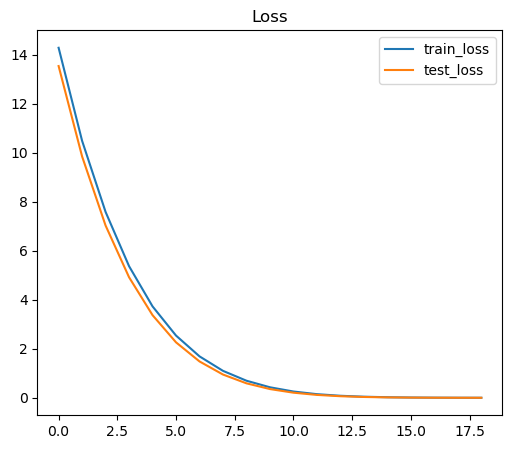

In [21]:
fig, ax1 = plt.subplots(1, 1, figsize=(6, 5))
ax1.set_title('Loss')
for dataset in ('train', 'test'):
  ax1.plot(metrics_history[f'{dataset}_loss'], label=f'{dataset}_loss')
ax1.legend()
plt.show()

In [26]:
# w=[2, -3.4], b=4.2
model.net.kernel, model.net.bias

(Param(
   value=Array([[ 1.9999983],
          [-3.3948512]], dtype=float32)
 ),
 Param(
   value=Array([4.1773686], dtype=float32)
 ))

## Summary

This section contains the first
implementation of a deep network (in this book)
to tap into the conveniences afforded
by modern deep learning frameworks,
such as MXNet :cite:`Chen.Li.Li.ea.2015`, 
JAX :cite:`Frostig.Johnson.Leary.2018`, 
PyTorch :cite:`Paszke.Gross.Massa.ea.2019`, 
and Tensorflow :cite:`Abadi.Barham.Chen.ea.2016`.
We used framework defaults for loading data, defining a layer,
a loss function, an optimizer and a training loop.
Whenever the framework provides all necessary features,
it is generally a good idea to use them,
since the library implementations of these components
tend to be heavily optimized for performance
and properly tested for reliability.
At the same time, try not to forget
that these modules *can* be implemented directly.
This is especially important for aspiring researchers
who wish to live on the leading edge of model development,
where you will be inventing new components
that cannot possibly exist in any current library.
